# My Daily Use of my iPhone via Screen Time
## By Sarah Hagen
### CPSC 222, Fall 2020

_Websites used:_
* [Pandas DataFrame website](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)
* [Pandas Series website](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)
* [Matplotlib website](https://matplotlib.org/)
* [SciPy stats website](https://docs.scipy.org/doc/scipy/reference/stats.html)

_Other sources:_
* Apple (Screen Time)

In [1]:
import utils
import matplotlib.pyplot as plt
import scipy.stats as stats

_Introduction: Briefly describe the project domain, the dataset, your hypotheses, and the classification task you implemented (e.g., what were you trying to classify in the dataset). You should also briefly describe your findings (e.g., what are your best classification results). See the project proposal guidelines in DA5 for more details on the requirements in this section._
## Introduction
The domain of my project is the device use domain. The data in in the table is being collected through Apple as an iOS tool. I am researching how much time I spend on certain categories on my phone (the top 3 categories) and my daily use of social media. The dataset involves several attributes either in minutes or the count:
* Social networking
* Entertainment
* Productivity
* Creativity
* Reading and reference
* Pickups
* Notifications
* Screen time

Some hypotheses I have with this domain are that:
* I spend more time with entertainment on my device than I do on social media
* I spend about two or three hours each day on social media
* I spend an average of 2 hours per day on entertainment
* My average pickup count is equal to my average notification count
* I spend more time on my phone, in general, after sunset than I do before sunset

The stakeholders who would be interested in my results are social media companies like Facebook or Snapchat, big technology companies like Apple, research doctors, and psychologists.

The classification task I implemented was the amount of times I pickup my phone.

_Data Analysis: Provide details about the dataset, data preparation, exploratory data analysis, and statistical analysis. See the project proposal guidelines in DA5 for more details on the requirements in this section._
## Data Analysis
The details within the dataset that I use:
* Social networking attribute is the social media applications like Snapchat, Instagram, and Facebook, I use on my phone.
* Entertainment attribute is the applications for television shows and movies (like Netflix or YouTube), music like Apple Music, and games.
* Productivity attribute is the applications for school and other such subjects.
* Other attribute is the applications that have no specific category like notes.
* Creativity attribute is the applications that are more on the creative side like cameras and photos.
* Reading and reference attribute is the applications that are book-like, for example news websites like BBC News.
* Pickups attribute is the number of times the phone is explicity used.
* Notifications attribute is how many notifications I receive on my phone, regardless of how it is displayed.
* Screen time attribute is how long I spent on my phone for the day.
* Less Used attribute is the difference between the screen time attribute and the total of minutes of screen time.

The data preparation I completed:
* Inputting "0" for the categories that were not in the top 3 for the day.

The data preparation I will need to do is:
* adding a column to the DataFrame called "Less Used(in minutes)" and add the other minutes that were not in the top 3 categories

#### Data Preparation
Calculating the difference in Top 3 and Not Top 3 categories for each day. Inputting the calculated minutes into the DataFrame.

In [2]:
screen_time_df = utils.load_csv_file("screen_time_data.csv")
top_3_row_total = []
not_top_3_col = []

for index in range(len(screen_time_df)):
    row_df = screen_time_df.iloc[index:index + 1]
    row_nums_ser = row_df[["Social Networking(in minutes)", 'Entertainment(in minutes)',
       'Productivity(in minutes)', 'Other(in minutes)',
       'Creativity(in minutes)', 'Reading and Reference(in minutes)']].sum()
    row_total = row_nums_ser.sum()
    top_3_row_total.append(row_total)

total_screen_time_ser = screen_time_df["Screen Time(in minutes)"]
for index in range(len(top_3_row_total)):
    total_screen_time = int(total_screen_time_ser.iloc[index:index + 1])
    not_top_3_col.append(total_screen_time - int(top_3_row_total[index]))

screen_time_df["Less Used(in minutes)"] = not_top_3_col

#### Exploratory Data Analysis
The data aggregation techniques I am going to apply are the sum, mean, standard deviation, minimum/maximum, median, and the range on each attribute.

In [3]:
social_networking_ser = utils.column_slicing("Social Networking(in minutes)", screen_time_df)
social_networking_total, social_networking_avg, social_networking_std_dev, social_networking_smallest_rounded, social_networking_largest_rounded, social_networking_median_rounded = utils.compute_stats(social_networking_ser)

entertainment_ser = utils.column_slicing("Entertainment(in minutes)", screen_time_df)
entertainment_total, entertainment_avg, entertainment_std_dev, entertainment_smallest_rounded, entertainment_largest_rounded, entertainment_median_rounded = utils.compute_stats(entertainment_ser)

productivity_ser = utils.column_slicing("Productivity(in minutes)", screen_time_df)
productivity_total, productivity_avg, productivity_std_dev, productivity_smallest_rounded, productivity_largest_rounded, productivity_median_rounded = utils.compute_stats(productivity_ser)

other_ser = utils.column_slicing("Other(in minutes)", screen_time_df)
other_total, other_avg, other_std_dev, other_smallest_rounded, other_largest_rounded, other_median_rounded = utils.compute_stats(other_ser)

creativity_ser = utils.column_slicing("Creativity(in minutes)", screen_time_df)
creativity_total, creativity_avg, creativity_std_dev, creativity_smallest_rounded, creativity_largest_rounded, creativity_median_rounded = utils.compute_stats(creativity_ser)

reading_reference_ser = utils.column_slicing("Reading and Reference(in minutes)", screen_time_df)
reading_reference_total, reading_reference_avg, reading_reference_std_dev, reading_reference_smallest_rounded, reading_reference_largest_rounded, reading_reference_median_rounded = utils.compute_stats(reading_reference_ser)

pickups_ser = utils.column_slicing("Pickups", screen_time_df)
pickups_total, pickups_avg, pickups_std_dev, pickups_smallest_rounded, pickups_largest_rounded, pickups_median_rounded = utils.compute_stats(pickups_ser)

notifications_ser = utils.column_slicing("Notifications", screen_time_df)
notifications_total, notifications_avg, notifications_std_dev, notifications_smallest_rounded, notifications_largest_rounded, notifications_median_rounded = utils.compute_stats(notifications_ser)

Displaying the results

In [31]:
# social networking
print("Social Networking Total:", social_networking_total, "minutes")
print("Social Networking Average:", social_networking_avg, "minutes")
print("Social Networking Standard Deviation:", social_networking_std_dev, "minutes")
print("Social Networking Least:", social_networking_smallest_rounded, "minutes")
print("Social Networking Most:", social_networking_largest_rounded, "minutes")
print("Social Networking Median:", social_networking_median_rounded, "minutes")
print("Social Networking Range:", social_networking_largest_rounded - social_networking_smallest_rounded, "minutes")

print()

# entertainment
print("Entertainment Total:", entertainment_total, "minutes")
print("Entertainment Average:", entertainment_avg, "minutes")
print("Entertainment Standard Deviation:", entertainment_std_dev, "minutes")
print("Entertainment Least:", entertainment_smallest_rounded, "minutes")
print("Entertainment Most:", entertainment_largest_rounded, "minutes")
print("Entertainment Median:", entertainment_median_rounded, "minutes")
print("Entertainment Range:", entertainment_largest_rounded - entertainment_smallest_rounded, "minutes")

print()

# productivity
print("Productivity Total:", productivity_total, "minutes")
print("Productivity Average:", productivity_avg, "minutes")
print("Productivity Standard Deviation:", productivity_std_dev, "minutes")
print("Productivity Least:", productivity_smallest_rounded, "minutes")
print("Productivity Most:", productivity_largest_rounded, "minutes")
print("Productivity Median:", productivity_median_rounded, "minutes")
print("Productivity Range:", productivity_largest_rounded - productivity_smallest_rounded, "minutes")

print()

# other
print("Other Total:", other_total, "minutes")
print("Other Average:", other_avg, "minutes")
print("Other Standard Deviation:", other_std_dev, "minutes")
print("Other Least:", other_smallest_rounded, "minutes")
print("Other Most:", other_largest_rounded, "minutes")
print("Other Median:", other_median_rounded, "minutes")
print("Other Range:", other_largest_rounded - other_smallest_rounded, "minutes")

print()

# creativity
print("Creativity Total:", creativity_total, "minutes")
print("Creativity Average:", creativity_avg, "minutes")
print("Creativity Standard Deviation:", creativity_std_dev, "minutes")
print("Creativity Least:", creativity_smallest_rounded, "minutes")
print("Creativity Most:", creativity_largest_rounded, "minutes")
print("Creativity Median:", creativity_median_rounded, "minutes")
print("Creativity Range:", creativity_largest_rounded - creativity_smallest_rounded, "minutes")

print()

# reading and reference
print("Reading and Reference Total:", reading_reference_total, "minutes")
print("Reading and Reference Average:", reading_reference_avg, "minutes")
print("Reading and Reference Standard Deviation:", reading_reference_std_dev, "minutes")
print("Reading and Reference Least:", reading_reference_smallest_rounded, "minutes")
print("Reading and Reference Most:", reading_reference_largest_rounded, "minutes")
print("Reading and Reference Median:", reading_reference_median_rounded, "minutes")
print("Reading and Reference Range:", reading_reference_largest_rounded - reading_reference_smallest_rounded, "minutes")

print()

# pickups
print("Pickups Total:", pickups_total, "times")
print("Pickups Average:", pickups_avg, "times")
print("Pickups Standard Deviation:", pickups_std_dev, "times")
print("Pickups Least:", pickups_smallest_rounded, "times")
print("Pickups Most:", pickups_largest_rounded, "times")
print("Pickups Median:", pickups_median_rounded, "times")
print("Pickups Range:", pickups_largest_rounded - pickups_smallest_rounded, "times")

print()

# notifications
print("Notifications Total:", notifications_total, "times")
print("Notifications Average:", notifications_avg, "times")
print("Notifications Standard Deviation:", notifications_std_dev, "times")
print("Notifications Least:", notifications_smallest_rounded, "times")
print("Notifications Most:", notifications_largest_rounded, "times")
print("Notifications Median:", notifications_median_rounded, "times")
print("Notifications Range:", notifications_largest_rounded - notifications_smallest_rounded, "times")

Social Networking Total: 10876 minutes
Social Networking Average: 157.6231884057971 minutes
Social Networking Standard Deviation: 56.934973602315246 minutes
Social Networking Least: 37 minutes
Social Networking Most: 305 minutes
Social Networking Median: 152.0 minutes
Social Networking Range: 268 minutes

Entertainment Total: 3031 minutes
Entertainment Average: 43.927536231884055 minutes
Entertainment Standard Deviation: 53.44824842796115 minutes
Entertainment Least: 0 minutes
Entertainment Most: 268 minutes
Entertainment Median: 34.0 minutes
Entertainment Range: 268 minutes

Productivity Total: 596 minutes
Productivity Average: 8.63768115942029 minutes
Productivity Standard Deviation: 13.450312717218264 minutes
Productivity Least: 0 minutes
Productivity Most: 51 minutes
Productivity Median: 0.0 minutes
Productivity Range: 51 minutes

Other Total: 579 minutes
Other Average: 8.391304347826088 minutes
Other Standard Deviation: 14.74410888467218 minutes
Other Least: 0 minutes
Other Most: 

##### Visualizations
The visualizations that will informatively present the attributes and relationships are bar charts, pie charts, histograms, and line plots.  
* For each attribute, I will use a histogram
* For each attribute, I will use a line plot
* All of them combined, I will use a pie chart
* Comparing the top 3 categories for the day to the not in the top 3 categories using a bar chart

For each attribute, I will use a histogram

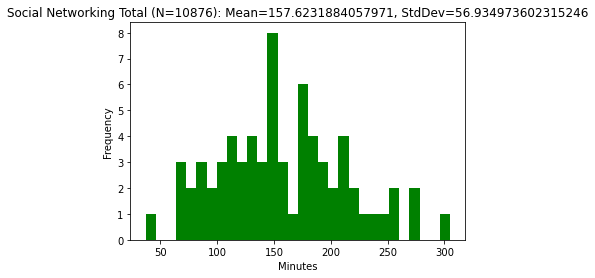

In [4]:
# for the social networking attribute
utils.histogram(social_networking_ser, "Social Networking", social_networking_total, social_networking_avg, social_networking_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of 8 times using social media for about 150 minutes (aka 2 hours and 30 minutes). My lowest was 1 time for about 45 minutes and 300 minutes (aka 5 hours). My average time spent on social media was about 158 minutes (aka 2 hours and 38 minutes). "N" represents the total number of minutes spent on social networking applications.

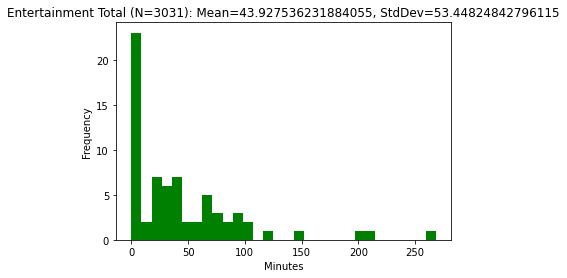

In [5]:
# for the entertainment attribute
utils.histogram(entertainment_ser, "Entertainment", entertainment_total, entertainment_avg, entertainment_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 30 times using the entertainment applications for between 0 and 5 minutes. My lowest was about 1 time between 120 minutes (aka 2 hours) to 265 minutes (aka 4 hours and 25 minutes). My average time spent on entertainment was about 44 minutes. "N" represents the total number of minutes spent on entertainment applications.

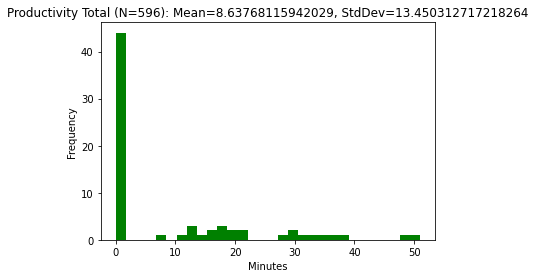

In [6]:
# for the productivity attribute
utils.histogram(productivity_ser, "Productivity", productivity_total, productivity_avg, productivity_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 48 times using the productivity applications for between 0 and 5 minutes. My lowest was less than 5 times between 8 minutes and 52 minutes. My average time spent on productivity applications was about 9 minutes. "N" represents the total number of minutes spent on productivity applications.

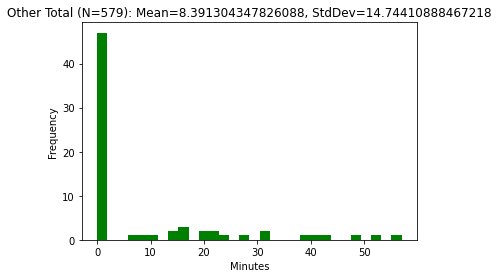

In [7]:
# for the other attribute
utils.histogram(other_ser, "Other", other_total, other_avg, other_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 48 times using the other category for between 0 and 5 minutes. My lowest was less than 5 times between 5 minutes and 57 minutes. My average time spent on the other category was about 8 minutes. "N" represents the total number of minutes spent on other applications.

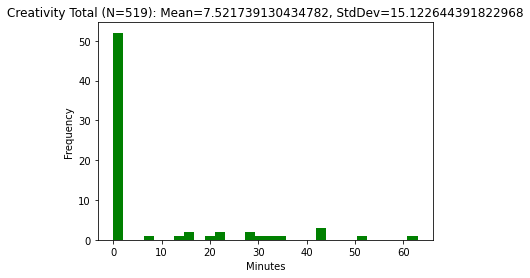

In [8]:
# for the creativity attribute
utils.histogram(creativity_ser, "Creativity", creativity_total, creativity_avg, creativity_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 52 times using the creativity applications for between 0 and 5 minutes. My lowest was less than 5 times between 9 minutes and 65 minutes (aka 1 hour and 5 minutes). My average time spent on the creativity applications was about 7 minutes and 30 seconds. "N" represents the total number of minutes spent on creativity applications.

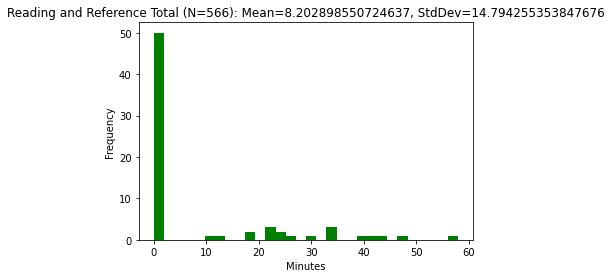

In [9]:
# for the reading and reference networking attribute
utils.histogram(reading_reference_ser, "Reading and Reference", reading_reference_total, reading_reference_avg, reading_reference_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 50 times using the reading and reference applications for between 0 and 5 minutes. My lowest was less than 5 times between 10 minutes and 58 minutes. My average time spent on reading and reference applications was about 8 minutes. "N" represents the total number of minutes spent on reading and reference applications.

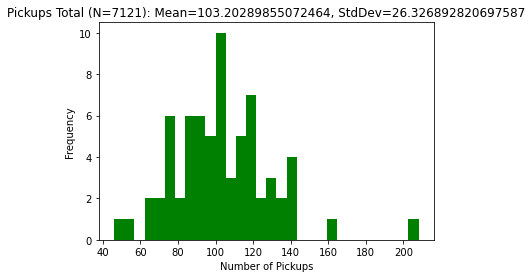

In [10]:
# for the pickups attribute
utils.histogram(pickups_ser, "Pickups", pickups_total, pickups_avg, pickups_std_dev, "Number of Pickups")

Above: This graph represents how many times I indirectly or directly, either unlocked my iPhone or directly used it in the dataset. This particular graph illustrates that I spent a maximum of about 10 times using my iPhone for at least 105 times. My lowest was about 1 time for about 48-58, 161-167, and 205-210 times. My average time spent on using my device was about 103 times. "N" represents the total number of times I spent using my iPhone.

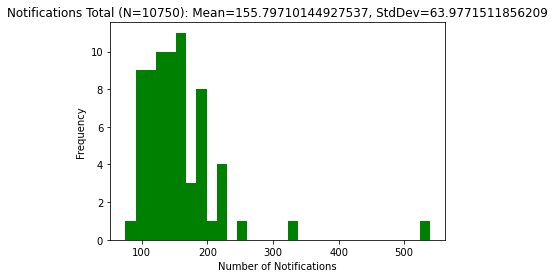

In [11]:
# for the notifications attribute
utils.histogram(notifications_ser, "Notifications", notifications_total, notifications_avg, notifications_std_dev, "Number of Notifications")

Above: This graph represents how many times I received a notification on my iPhone in the dataset. This particular graph illustrates that I received a maximum of about 175 notifications for about 11 times. My lowest was about 1 time for about 50-97, 201-210, 250, 330, and 550 notifications. My average number of notifications was about 156. "N" represents the total number of notifcations I received.

Below: For each attribute, I will use a line plot

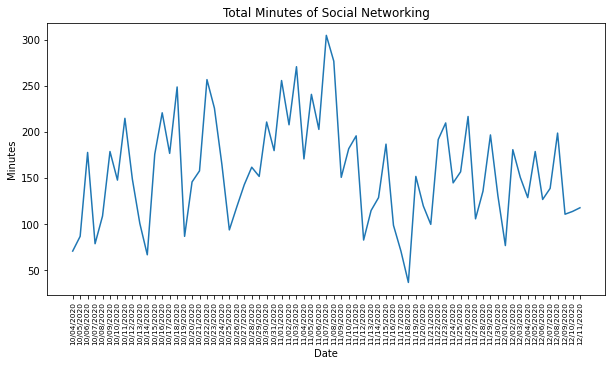

In [12]:
# for the social networking attribute
utils.line_plot(screen_time_df.index, social_networking_ser, "Minutes", "Social Networking")

Above: This graph represents the total minutes I spent on social networking applications from October 04, 2020 to December 13, 2020. The lowest date I spent on social networking was December 18, 2020 for 37 minutes. The highest date I spent on social networking was on November 07, 2020 for 305 minutes (aka 5 hours and 5 minutes). Overtime, I balance my time with social networking.

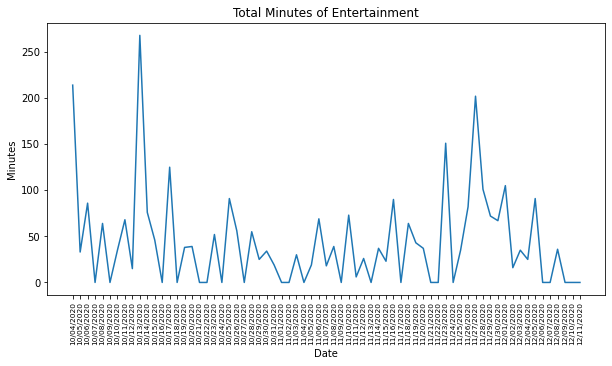

In [13]:
# for the entertainment attribute
utils.line_plot(screen_time_df.index, entertainment_ser, "Minutes", "Entertainment")

Above: This graph represents the total minutes I spent on entertainment applications from October 04, 2020 to December 13, 2020. The lowest date I spent on entertainment were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on entertainment was October 13, 2020 for 268 minutes (aka 4 hours and 28 minutes). Overtime, I balance my time with entertainment, and generally do not spend more than 150 minutes with a few spikes.

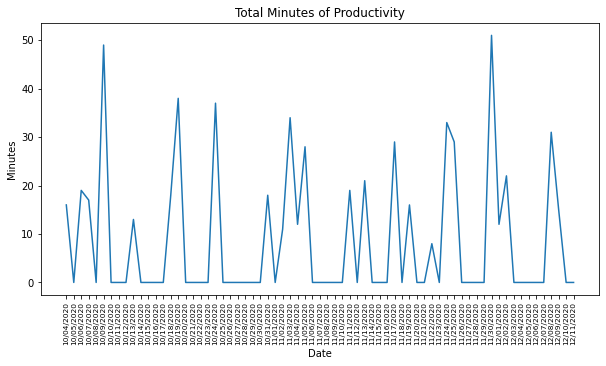

In [14]:
# for the productivity attribute
utils.line_plot(screen_time_df.index, productivity_ser, "Minutes", "Productivity")

Above: This graph represents the total minutes I spent on productivity applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 30, 2020 for 51 minutes. Overtime, I usually either use it for a long period of time or I do not.

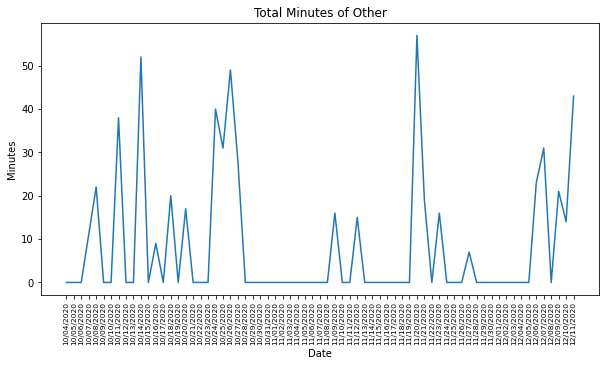

In [15]:
# for the other attribute
utils.line_plot(screen_time_df.index, other_ser, "Minutes", "Other")

Above: This graph represents the total minutes I spent on the other category from October 04, 2020 to December 13, 2020. The lowest date I spent on the other category were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 20, 2020 for 57 minutes. Overtime, I usually either use it for a long period of time or I do not.

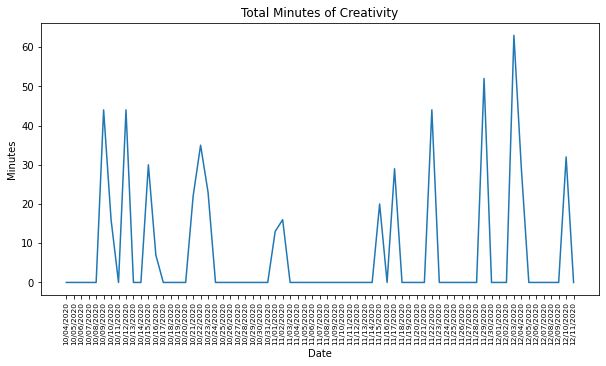

In [16]:
# for the creativity attribute
utils.line_plot(screen_time_df.index, creativity_ser, "Minutes", "Creativity")

Above: This graph represents the total minutes I spent on creativity applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on creativity applications was December 03, 2020 for 63 minutes (aka 1 hour and 3 minutes). Overtime, I usually either use it for a long period of time or I do not.

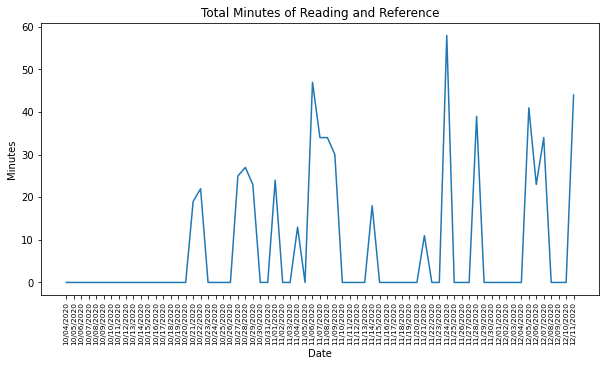

In [17]:
# for the reading and reference attribute
utils.line_plot(screen_time_df.index, reading_reference_ser, "Minutes", "Reading and Reference")

Above: This graph represents the total minutes I spent on reading and reference applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 24, 2020 for 58 minutes. Overtime, I usually either use it for a long period of time or I do not.

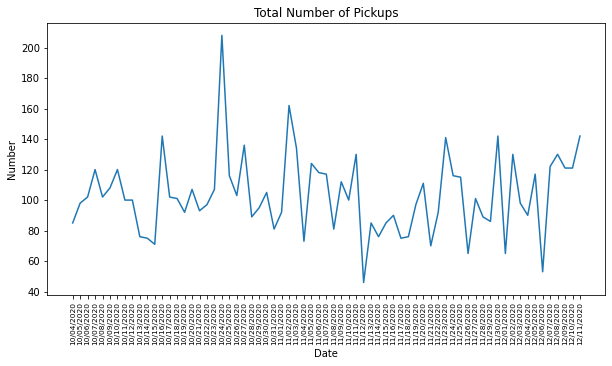

In [18]:
# for the pickups attribute
utils.line_plot(screen_time_df.index, pickups_ser, "Number", "Pickups")

Above: This graph represents the total number of pickups from October 04, 2020 to December 13, 2020. The lowest date I spent picking up my phone was November 12, 2020 for a total of 46 pickups. The highest date I spent picking up my phone was October 24, 2020 for a total of 208 pickups. Overtime, I usually either use my phone often or I do not.

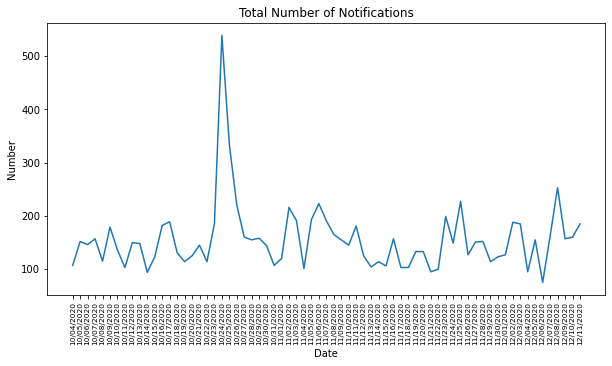

In [19]:
# for the notifications attribute
utils.line_plot(screen_time_df.index, notifications_ser, "Number", "Notifications")

Above: This graph represents the total number of notifications from October 04, 2020 to December 13, 2020. The lowest date I received notifications on my phone was December 06, 2020 for a total of 75 notifications. The highest date I received notifications on my phone was October 24, 2020 for a total of 539 notifications. Overtime, I usually receive less than 300 notifications on my phone.

Below: All of them combined, I will use a pie chart

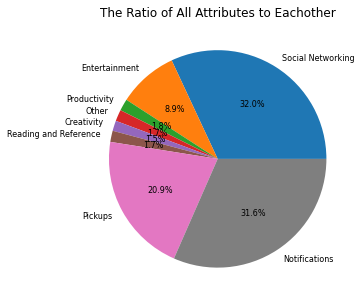

In [20]:
utils.pie_chart([social_networking_total, entertainment_total, productivity_total, other_total, creativity_total, reading_reference_total, pickups_total, notifications_total])

Above: This pie chart represents the percent of each category compared to the other categories from October 04, 2020 to December 13, 2020. My most used category is social networking by 0.4%. Productivity, other, creativity, and reading and reference make up less than 7% of the chart and are less than entertainment (8.9%). My pickups and notifications make up majority of the pie at a total of 52.5%.

Below: Comparing the top 3 categories for the day to the not in the top 3 categories using a bar chart

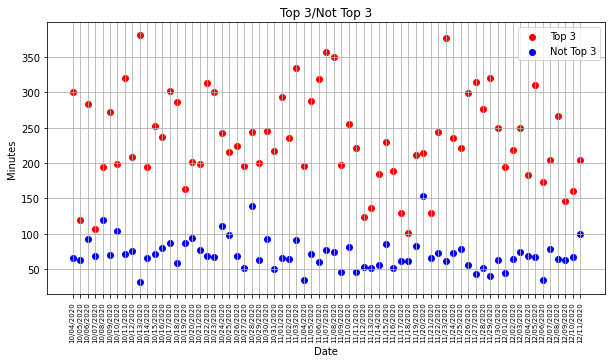

In [21]:
plt.figure(figsize=[10.0, 5.0])
plt.scatter(screen_time_df.index, top_3_row_total, color="red", label="Top 3")
plt.scatter(screen_time_df.index, not_top_3_col, color="blue", label="Not Top 3")
plt.title("Top 3/Not Top 3")
plt.xlabel("Date")
plt.ylabel("Minutes")
plt.xticks(rotation=90, horizontalalignment="center", fontsize=7)
plt.grid()
plt.legend()
plt.show()

The top three categories compared to the categories that did not get top three for the day (excluding pickups and notifications because they are their own categories) were higher than 100 minutes while not top three were generally lower than 125 minutes. The total for top three were always higher than categories not in the top three, respectively, for each day.

#### Hypothesis Testing
The hypotheses that I will test are:
1. On average, I spend more time with entertainment on my device than I do on social media
1. On average, I spend about two or three hours each day on social media
1. On average, I spend an average of 2 hours per day on entertainment
1. My average pickup count is equal to my average notification count
1. On average, I spend more time on my phone, in general, after sunset than I do before sunset

##### 1. On average, I spend more time with entertainment on my device than I do on social media
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu1\leq\mu2$  
$H_{1}$: $\mu1>\mu2$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{d}-\mu_{d}}{S_\overline{d}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $50-1$ = $49$ = $40$  
Since the length of the dataset is closest to 40, the $df$ is declared as $40$  
$\alpha$ = $0.05$  
two-tailed test  
_used t-table to calculate t_  
$t$(critical) = $1.684$  
Decision Rule:
   * if t-computed is $>$ +1.684 then Reject $H_{0}$
   * if t-computed is $\leq$ +1.684 then Do Not Reject $H_{0}$

1. Make a Decision

In [22]:
alpha = 0.05
t_computed, p_value = stats.ttest_rel(entertainment_ser, social_networking_ser)
print("t-computed:", t_computed, ", p-value:", p_value / 2)
if p_value / 2 < alpha:
    print("Reject H0, p-value:", p_value / 2)
else:
    print("Do Not Reject H0, p-value:", p_value / 2)

t-computed: -10.925668048038375 , p-value: 6.471092569930724e-17
Reject H0, p-value: 6.471092569930724e-17


The above code cell calculated t-computed to be -10.760, so  
Since t-computed (-10.760) is $<$ t-critical (+1.684):
* Do Not Reject $H_{0}$  
* Succeed to Reject $H_{1}$  
* $\mu1>\mu2$  

In conclusion, the mean duration for entertainment use is greater than the mean duration 